#  Optical Flow Method

In [1]:
import os
import cv2
import numpy as np
from skimage import morphology
import matplotlib.pyplot as plt

#  Input folder path
input_folder = './dataOneDay'

#  Initialize lists to store original and processed images
original_images = []
processed_images = []

#  Set minimum rain area threshold
min_rain_area = 10  # Adjust as needed

#  Iterate through each image in the folder
for filename in sorted(os.listdir(input_folder)):
    #  Check if the file is an image
    if filename.endswith('.png'):
        input_path = os.path.join(input_folder, filename)
        
        #  Step 1: Read the image
        img = cv2.imread(input_path)
        if img is None:
            print(f"Error: Image {filename} failed to load, skipping this file.")
            continue
        
        #  Step 2: Convert to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        #  Step 3: Save the unprocessed grayscale image to original_images
        original_images.append(gray_img)
        
        #  Step 4: Apply binary thresholding
        _, binary_img = cv2.threshold(gray_img, 30, 255, cv2.THRESH_BINARY)
        
        #  Step 5: Remove small areas
        binary_img = morphology.remove_small_objects(binary_img.astype(bool), min_rain_area)
        binary_img = (binary_img * 255).astype(np.uint8)
        
        #  Step 6: Apply mask
        processed_img = cv2.bitwise_and(gray_img, gray_img, mask=binary_img)
        
        #  Step 7: Normalize
        normalized_img = (processed_img / 255.0)  # Normalize to 0-1 range
        
        #  Add processed image to processed_images
        processed_images.append(normalized_img)

print("Image processing complete. `original_images` and `processed_images` data are ready.")


Image processing complete. `original_images` and `processed_images` data are ready.


In [52]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

#  Optical flow feature extraction function
def compute_optical_flow_features(images, step_size=1):
    flow_features = []
    for i in range(0, len(images) - step_size):
        prev_img = (images[i] * 255).astype(np.uint8)  # Restore to 0-255 range
        next_img = (images[i + step_size] * 255).astype(np.uint8)
        
        #  Calculate optical flow
        flow = cv2.calcOpticalFlowFarneback(prev_img, next_img, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        
        #  Resize features to reduce computational complexity
        mag_resized = cv2.resize(mag, (120, 120), interpolation=cv2.INTER_AREA).flatten()
        ang_resized = cv2.resize(ang, (120, 120), interpolation=cv2.INTER_AREA).flatten()
        
        #  Combine magnitude and angle features
        flow_feature = np.concatenate((mag_resized, ang_resized))
        flow_features.append(flow_feature)
    
    return np.array(flow_features)

#  Optical flow feature extraction for processed images
time_steps = 12
pred_steps = 12

#  Assume `processed_images` is the preprocessed set of images
flow_features = compute_optical_flow_features(processed_images)
X, y = [], []
for i in range(len(flow_features) - time_steps - pred_steps + 1):
    X.append(flow_features[i:i + time_steps])
    y.append(flow_features[i + time_steps:i + time_steps + pred_steps])

X = np.array(X)
y = np.array(y)
feature_dim = X.shape[2]

#  Build Optical Flow-LSTM model
def build_optical_flow_lstm_model(time_steps, feature_dim, pred_steps):
    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(time_steps, feature_dim), return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(16, activation='relu', return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(pred_steps * feature_dim))
    model.add(tf.keras.layers.Reshape((pred_steps, feature_dim)))
    
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='mse')
    return model

#  Initialize model
model2 = build_optical_flow_lstm_model(time_steps, feature_dim, pred_steps)
model2.summary()

#  Split dataset
train_ratio = 0.8
split_index = int(train_ratio * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 12, 32)            3690624   
                                                                 
 dropout_31 (Dropout)        (None, 12, 32)            0         
                                                                 
 lstm_28 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_32 (Dropout)        (None, 16)                0         
                                                                 
 dense_20 (Dense)            (None, 32)                544       
                                                                 
 dense_21 (Dense)            (None, 345600)            11404800  
                                                                 
 reshape_16 (Reshape)        (None, 12, 28800)       

In [53]:
from tensorflow.keras.callbacks import EarlyStopping

#  Set up EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=10,             # Stop if validation loss does not improve for 10 epochs
    min_delta=0.001,         # Consider as no improvement if change is less than 0.001
    restore_best_weights=True  # Restore weights from the epoch with the lowest validation loss
)

#  Train the model with EarlyStopping callback
history = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,              # Maximum of 300 epochs
    batch_size=1,
    callbacks=[early_stopping]  # Use EarlyStopping
)


Epoch 1/300
211/211 [==============================] - 4s 14ms/step - loss: 5.5977 - val_loss: 5.2716
Epoch 2/300
211/211 [==============================] - 3s 13ms/step - loss: 3.7331 - val_loss: 3.6968
Epoch 3/300
211/211 [==============================] - 3s 13ms/step - loss: 2.7149 - val_loss: 4.1626
Epoch 4/300
211/211 [==============================] - 3s 13ms/step - loss: 3.8016 - val_loss: 5.6447
Epoch 5/300
211/211 [==============================] - 3s 13ms/step - loss: 3.9051 - val_loss: 5.0468
Epoch 6/300
211/211 [==============================] - 3s 13ms/step - loss: 3.3198 - val_loss: 4.5187
Epoch 7/300
211/211 [==============================] - 3s 13ms/step - loss: 3.4555 - val_loss: 4.5158
Epoch 8/300
211/211 [==============================] - 3s 13ms/step - loss: 3.6828 - val_loss: 4.3714
Epoch 9/300
211/211 [==============================] - 3s 13ms/step - loss: 3.0674 - val_loss: 3.7519
Epoch 10/300
211/211 [==============================] - 3s 13ms/step - loss: 3.111

# As you can see, the lost is very high (higher than 1)

25
X_test shape: (1, 12, 28800)
y_actual shape: (1, 12, 28800)
X_test shape: (1, 12, 28800)
Expected input shape for model2: (None, 12, 28800)
1/1 [==============================] - 0s 193ms/step
Mean Squared Error on Test Set: 2.9347915649414062


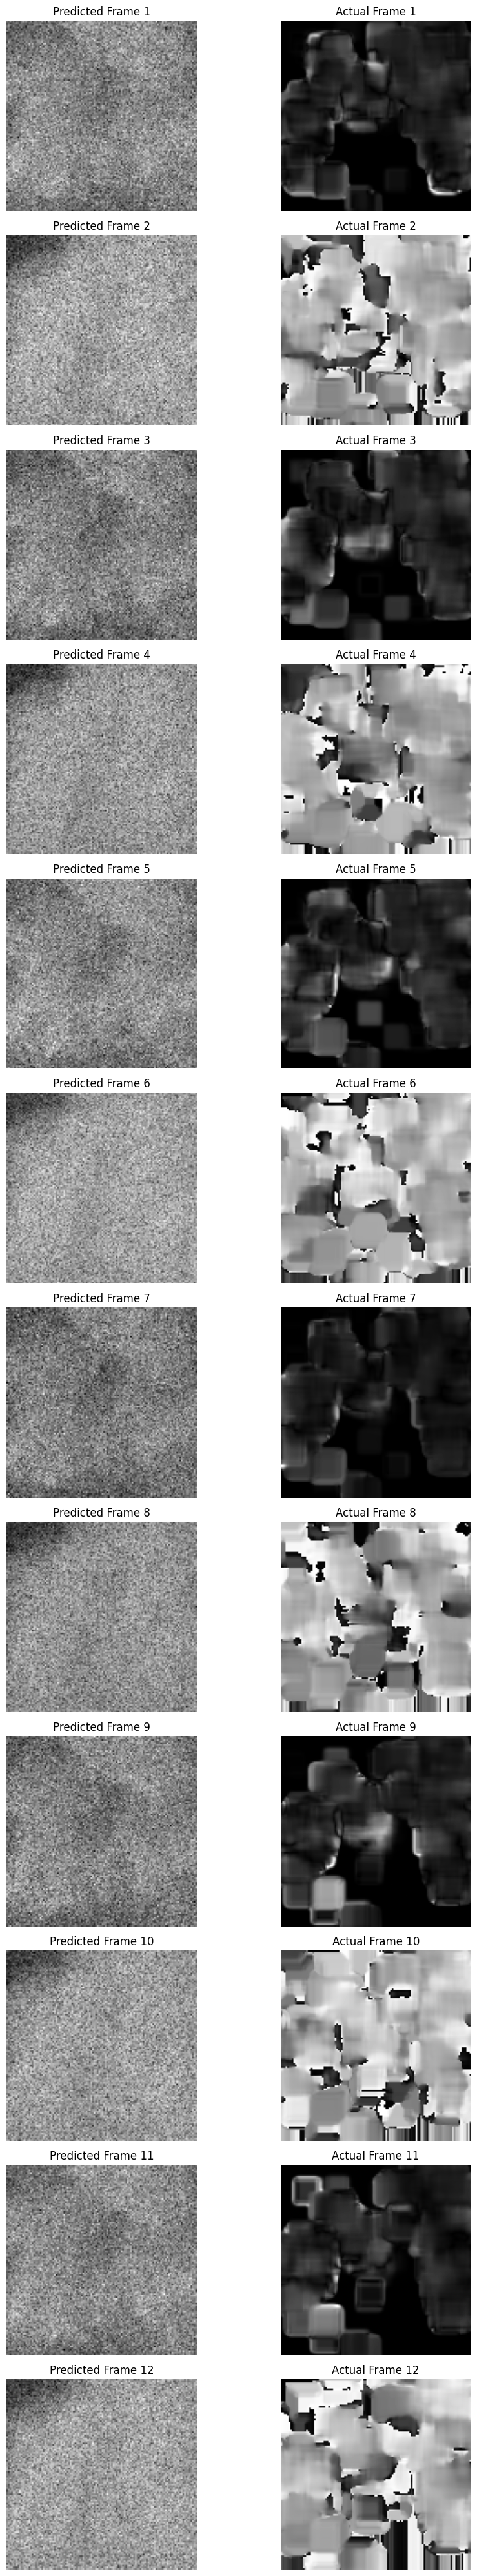

In [61]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

#  Folder path
test_folder = './dataOneDayTest'
time_steps = 12
pred_steps = 12

#  Load test image data and resize to the training dimensions (120x120)
test_images = []
image_files = sorted([f for f in os.listdir(test_folder) if f.endswith('.png')])
print(len(image_files))
for file in image_files:
    img = cv2.imread(os.path.join(test_folder, file), cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(img, (120, 120), interpolation=cv2.INTER_AREA)  # Ensure consistent dimensions
    normalized_img = resized_img / 255.0  # Normalize
    test_images.append(normalized_img)

#  Optical flow feature extraction function
def compute_optical_flow_features(images, step_size=1):
    flow_features = []
    for i in range(0, len(images) - step_size):
        prev_img = (images[i] * 255).astype(np.uint8)  # Restore to 0-255 range
        next_img = (images[i + step_size] * 255).astype(np.uint8)

        #  Calculate optical flow
        flow = cv2.calcOpticalFlowFarneback(prev_img, next_img, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

        #  Resize and combine magnitude and angle features
        mag_resized = cv2.resize(mag, (120, 120), interpolation=cv2.INTER_AREA).flatten()
        ang_resized = cv2.resize(ang, (120, 120), interpolation=cv2.INTER_AREA).flatten()
        flow_feature = np.concatenate((mag_resized, ang_resized))
        
        flow_features.append(flow_feature)
    
    return np.array(flow_features)

#  Generate input and labels for the test set
flow_features = compute_optical_flow_features(test_images)
#  If the total number of images is less than time_steps + pred_steps, give a warning
if len(flow_features) < time_steps + pred_steps:
    print(f"Insufficient images in test set to generate samples. Required at least {time_steps + pred_steps}, found {len(flow_features)}.")
else:
    #  Generate input and labels for the test set
    X_test, y_actual = [], []
    for i in range(len(flow_features) - time_steps - pred_steps + 1):
        X_test.append(flow_features[i:i + time_steps])
        y_actual.append(flow_features[i + time_steps:i + time_steps + pred_steps])

    X_test = np.array(X_test)
    y_actual = np.array(y_actual)

    #  Check shapes of generated X_test and y_actual
    print("X_test shape:", X_test.shape)
    print("y_actual shape:", y_actual.shape)


#  Debug: Output shape information
print("X_test shape:", X_test.shape)
print("Expected input shape for model2:", model2.input_shape)

#  Predict using the model
try:
    y_pred = model2.predict(X_test)
    #  Reshape to 120x120 for visualization
    y_pred = y_pred.reshape(-1, 120, 120)
    y_actual = y_actual.reshape(-1, 120, 120)

    #  Calculate MSE or other metrics to evaluate prediction quality
    mse = mean_squared_error(y_actual.flatten(), y_pred.flatten())
    print(f"Mean Squared Error on Test Set: {mse}")

    #  Visualize comparison of the first few predicted and actual results
    fig, axs = plt.subplots(12, 2, figsize=(10, 40))
    for i in range(12):
        #  Display predicted result
        axs[i, 0].imshow(y_pred[i], cmap='gray')
        axs[i, 0].set_title(f"Predicted Frame {i+1}")
        axs[i, 0].axis('off')
        
        #  Display actual result
        axs[i, 1].imshow(y_actual[i], cmap='gray')
        axs[i, 1].set_title(f"Actual Frame {i+1}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

except ValueError as e:
    print("Error during prediction:", e)


In [ ]:
#  Due to the need to reduce resolution and the overall complexity of the storm, the performance is very poor.
